In this notebook, we'll look at building a visualiser for a train of binary pulses.

We need a chart for the input, and a chart for each buffer in a time series.

We can use https://matplotlib.org/devdocs/gallery/lines_bars_and_markers/broken_barh.html. This takes a start and stop value. https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.broken_barh.html?highlight=broken%20barh#matplotlib.axes.Axes.broken_barh

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook

We need a function that takes a multiD array of binary values over time and computes the intervals for the broken bar. 

We can use a buffer style object as for our time data on our sound visualiser. For each iteration we add into an array of values ``` windows = np.zeros(shape=(stages+1, 2, win_length))```.

We can use a time-series object with a shape of 1,1.

If we have 32 time steps in a window and a spacing of 1 then we have 64 ticks. We update the first row (both entries or first entry) for the input, then use the time_series ff_output and fb_output to update the array from 1: for each of for columns.

We then have a function that takes a 1D array of binary values and computes the bars. We just need to get the index of the 1s (using np.nonzero(a)) and times by (spacing+1) and then have those values +1

In [2]:
array = np.asarray([0,0,0,1,1,0,1,0]); print(array); print(np.nonzero(array))

[0 0 0 1 1 0 1 0]
(array([3, 4, 6]),)


In [3]:
zipped = zip(np.nonzero(array)[0], np.nonzero(array)[0]+1)
for z in zipped:
    print(z)

(3, 4)
(4, 5)
(6, 7)


(7, 2)

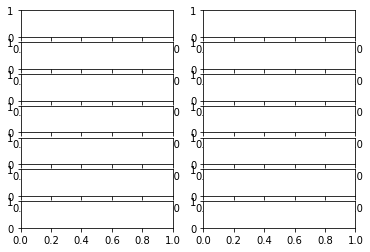

In [4]:
figure, axes = plt.subplots(6+1, 2)
axes.shape

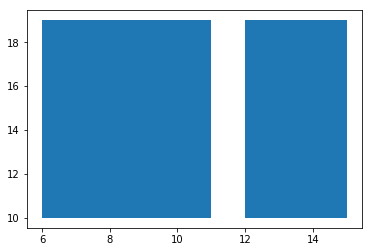

In [5]:
fig, ax = plt.subplots()
ax.broken_barh([(6, 3), (8, 3), (12, 3)], (10, 9), facecolors='tab:blue')

plt.show()

In [6]:
array2 = array.copy()
array2[:] = 1; print(array2)

[1 1 1 1 1 1 1 1]


In [7]:
def random_binary(size):
    """Generate a random binary 1D array.
    
    Args:
        high: largest random int.
        size: integer length of 1D array.
        
    Returns:
        a 1D array of length size.
    """
    while True:
        yield np.random.randint(2, size=(size,1))

In [8]:
def compute_bars(array, spacing):
    """Compute broken bar intervals based on non-zero array values."""
    indices = np.nonzero(array)[0]*(spacing+1)
    intervals = zip(indices, [1]*indices.shape[0])
    return list(intervals)

<IPython.core.display.Javascript object>


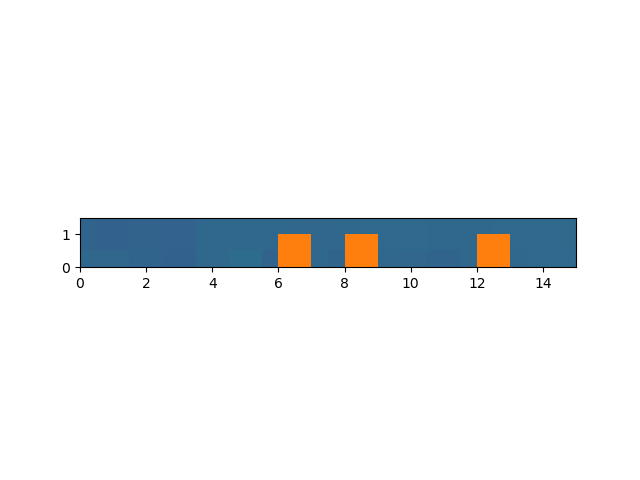

In [9]:
%matplotlib notebook
xranges = compute_bars(array, 1)

fig, ax = plt.subplots()
ax.broken_barh(list(xranges), [0,1], facecolors='tab:orange')
ax.set_xlim(0, 15)
ax.set_ylim(0, 1.5)
plt.show()

In [10]:
import time
from matplotlib.animation import FuncAnimation

def add_to_array(array, frame):
    """Add a frame to a rolling array."""
    array = np.roll(array, -1, axis=2)
    # Add frame to end of buffer
    array[..., -1] = frame
    return array

class BinaryVisualizer:
    """Object to visualise processing of binary data."""

    def __init__(self, input_generator, buffers, win_length, spacing):
        """Initialise.

        Args:
            input_generator: generator object that outputs an input for
            each iteration.
            buffers: a time-series object that has M stages.
            win_length: integer length of window to show.
            spacing: spacing between binary units.
        """
        # Store input locally
        self.input_gen = input_generator
        self.buffers = buffers
        self.spacing = spacing
        # Get stages in time series object
        self.stages = len(buffers.time_series)
        # Create a set of vertically stacked subplots - one for FF and one for FB
        self.figure, self.axes = plt.subplots(self.stages+1, 2)
        # Create windows of data for display - array as a 3D matrix
        self.windows = np.zeros(shape=(self.stages+1, 2, win_length))
        # Initialising animation
        self.animation = FuncAnimation(
            self.figure, self.update, save_count=200)
        self.update_plots()
        for ax in self.axes.flatten():
            ax.xaxis.set_major_locator(plt.NullLocator())
            # ax.yaxis.set_major_locator(plt.NullLocator())
            ax.set_xlim(0, win_length*(spacing+1))
            ax.set_ylim(0, 1)
        plt.subplots_adjust(wspace=0.5)

    def update_plots(self):
        """Update plots."""
        # Plot input values - duplicate across top
        self.temp_plots = list()
        xranges = compute_bars(self.windows[0, 0, :], self.spacing)
        self.temp_plots.append(self.axes[0, 0].broken_barh(xranges, [0,1]))
        self.temp_plots.append(self.axes[0, 1].broken_barh(xranges, [0,1]))
        # Iterate through axes for time stages                   
        for i in range(1, self.stages+1):
            # Plot FF values
            xranges = compute_bars(self.windows[i, 0, :], self.spacing)
            self.temp_plots.append(self.axes[i, 0].broken_barh(xranges, [0,1]))
            # plot FB values
            xranges = compute_bars(self.windows[i, 1, :], self.spacing)
            self.temp_plots.append(self.axes[i, 1].broken_barh(xranges, [0,1]))
    
    def update(self, frame):
        """Update the visualisations."""
        # Clear old plots
        for temp_plot in self.temp_plots:
            temp_plot.remove()
        # Get input data
        # print("updating")
        input_data = next(self.input_gen)
        self.buffers.add(input_data)
        ff = self.buffers.ff_output
        fb = self.buffers.fb_output
        # Create a blank 2D data frame the same size as the 2Ds of window
        data_frame = np.zeros(
            shape=(self.windows.shape[0], self.windows.shape[1])
        )
        data_frame[0, :] = input_data
        data_frame[1:, 0] = ff.reshape(self.stages)
        data_frame[1:, 1] = fb.reshape(self.stages)
        self.windows = add_to_array(self.windows, data_frame)
        self.update_plots()
        time.sleep(0.25)
        return self.figure

    def show(self):
        """Show the visualisations."""
        plt.show()

In [11]:
from src.var_processor.time_series import TimeSeries

ts = TimeSeries(1,1,6,8)

<IPython.core.display.Javascript object>


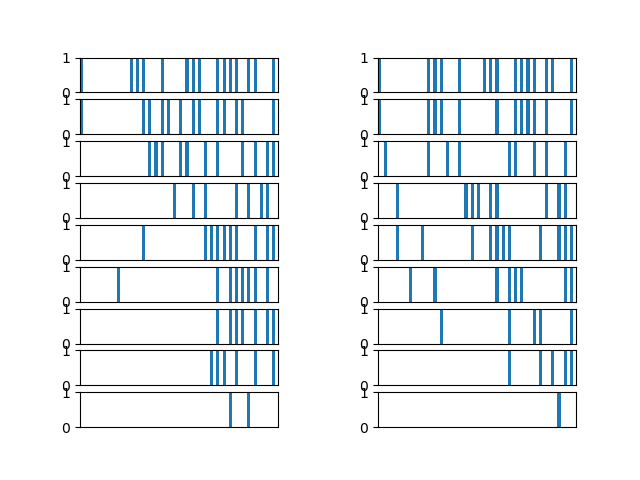

In [12]:
bv = BinaryVisualizer(random_binary(1),ts, 32,1)

I need to remove the old charts?

In [13]:
bv.update_plots()

In [14]:
bv.windows.shape

(9, 2, 32)

<IPython.core.display.Javascript object>


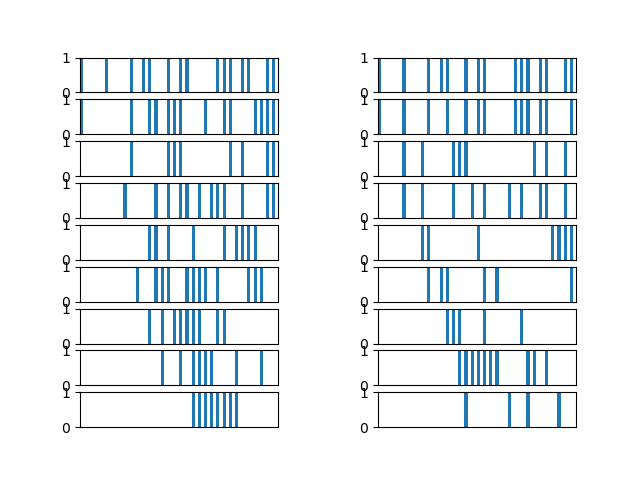

In [15]:
bv.update(None)

In [16]:
bv.buffers

FF

array([[[1]],

       [[0]],

       [[1]],

       [[0]],

       [[1]],

       [[1]],

       [[1]],

       [[0]]])

---

FB

array([[[1]],

       [[0]],

       [[0]],

       [[0]],

       [[1]],

       [[1]],

       [[1]],

       [[0]]])

---

Latest

array([[[1]],

       [[0]],

       [[1]],

       [[0]],

       [[1]],

       [[1]],

       [[1]],

       [[0]]], dtype=uint8)

---

In [17]:
bv.windows

array([[[0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,
         0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.]],

       [[1., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
         1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0.]],

       [[0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0.,
         0., 0., 1., 1., 0., 0., 0., 1.

## On Video Data

In [19]:
from src.var_processor.pb_threshold import pb_threshold
import cv2

def create_pyramid(image):
    """Create a gaussian image pyramid from the image."""
    #image = reduce_to_2(image, reduce)
    rows, cols = image.shape
    scales = rows.bit_length()-1
    # Create list to hold scales
    pyramid = [image]
    current_image = image
    for i in range(scales):
        rows, cols = current_image.shape
        lower_level = cv2.pyrDown(
            current_image,
            (rows//2, cols//2)
        )
        # Save downsampled array in pyramid
        pyramid.append(lower_level)
        current_image = lower_level
    return pyramid

from src.sources.capture import VideoSource

def frame():
    """Generate a 1D array from a video signal."""
    video = VideoSource()
    video.start()
    while True:
        # Get a frame from the video
        yield video.read()[1][:, :, 1]

def video_stream():
    """Generate a 1D array from a video signal."""
    while True:
        # Get a frame from the video
        image = video.read()[1][:, :, 1]
        # Create an image pyramid
        pyramid = create_pyramid(image)
        # Convert from 2d > 1D
        flat = pyramid[-2].flatten()
        # Reshape to a column vector
        flat = flat.reshape(-1, 1)
        # Threshold to binary
        yield pb_threshold(flat)

In [63]:
src = 0
cap = cv2.VideoCapture(src)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 1)
grabbed, frame = cap.read()

In [64]:
grabbed, frame = cap.read(); print(grabbed, frame.shape)

True (120, 160, 3)


<IPython.core.display.Javascript object>


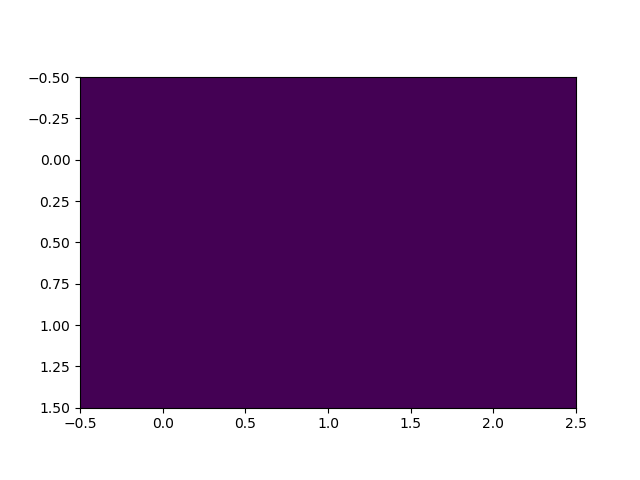

In [95]:
image = cap.read()[1][:, :, 1]
pyr = create_pyramid(image)
plt.imshow(pyr[-1])

In [62]:
cap.release()

<IPython.core.display.Javascript object>


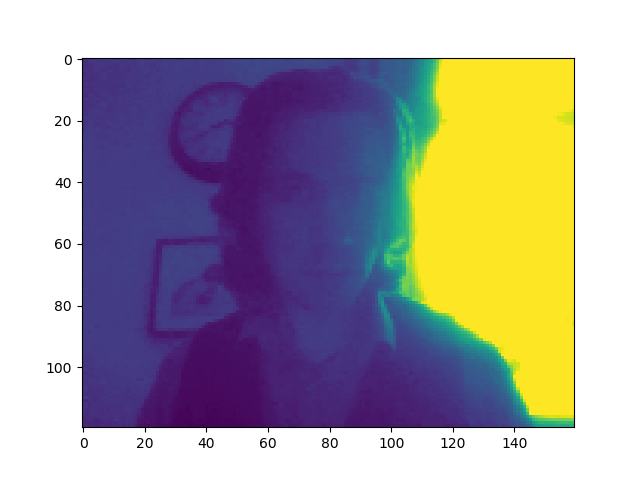

In [58]:
plt.imshow(image)

In [24]:
video.read()[1][:, :, 1].mean()

103.67449869791666